# Data Glacier Week 2

Author: Raquel Castromonte

## Part 1: Background Information

**The Client**

XYZ is a private firm in US. Due to remarkable growth in the Cab Industry in last few years and multiple key players in the market, it is planning for an investment in Cab industry and as per their Go-to-Market(G2M) strategy they want to understand the market before taking final decision.

**Project delivery:**

You have been provided with multiple data sets that contains information on 2 cab companies. Each file (data set) provided represents different aspects of the customer profile. XYZ is interested in using your actionable insights to help them identify the right company to make their investment.

The outcome of your delivery will be a presentation to XYZ’s Executive team. This presentation will be judged based on the visuals provided, the quality of your analysis and the value of your recommendations and insights. 

### Hypothesis

1. Which company has the most rides all-time (from 2016-2018)?

2. Which company is the most reliable during the holiday seasons?

3. Does different genders show preference on one company over another?

4. Which company has greater number of rides based on city?

5. Which company brought in more income per year?

Areas to investigate:

Which company has maximum cab users at a particular time period?
Does margin proportionally increase with increase in number of customers?
What are the attributes of these customer segments?
Although not required, we encourage you to document the process and findings

- What is the business problem?
- What are the properties of the data provided (data intake report)
- What steps did you take in order to create an applicable data set?
- How did you prepare and perform your analysis?
- What type of analysis did you perform?
- Why did you choose to use certain analytical techniques over others?
- What were the results?

Prepare a presentation that summarizes your analysis and recommendations and identify which company is performing better and is a better investment opportunity for XYZ.

## Part 2: Importing Data

Time period of data is from 31/01/2016 to 31/12/2018.

* **Cab_Data.csv** – this file includes details of transaction for 2 cab companies
* **City.csv** – this file contains list of US cities, their population and number of cab users
* **Customer_ID.csv** – this is a mapping table that contains a unique identifier which links the customer’s demographic details
* **Transaction_ID.csv** – this is a mapping table that contains transaction to customer mapping and payment mode

In [1]:
import pandas as pd
import requests
import io
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt

In [2]:
# Downloading the raw csv file from your GitHub account
cab_data = "https://raw.githubusercontent.com/DataGlacier/DataSets/main/Cab_Data.csv" 
city_data = "https://raw.githubusercontent.com/DataGlacier/DataSets/main/City.csv"
customer_data = "https://raw.githubusercontent.com/DataGlacier/DataSets/main/Customer_ID.csv"
transaction_data = "https://raw.githubusercontent.com/DataGlacier/DataSets/main/Transaction_ID.csv"

download_cab = requests.get(cab_data).content
download_city = requests.get(city_data).content
download_customer = requests.get(customer_data).content
download_transaction = requests.get(transaction_data).content

cab = pd.read_csv(io.StringIO(download_cab.decode('utf-8'))) # Reading the downloaded content and turning it into a pandas dataframe
city = pd.read_csv(io.StringIO(download_city.decode('utf-8')))
customer = pd.read_csv(io.StringIO(download_customer.decode('utf-8')))
transaction = pd.read_csv(io.StringIO(download_transaction.decode('utf-8')))

print("size of cab data is:", cab.shape) #there were 359392 total transactions
print("size of city data is:", city.shape) #there are 20 cities
print("size of customer data is:", customer.shape) #there are 49171 customers in the database
print("size of transaction data is:", transaction.shape) #there were 440098 transactions

#extra dataset- US holidays
holiday= pd.read_csv("US Holiday Dates.csv")
print("size of holiday data is:", holiday.shape) #there were 440098 transactions

size of cab data is: (359392, 7)
size of city data is: (20, 3)
size of customer data is: (49171, 4)
size of transaction data is: (440098, 3)
size of holiday data is: (342, 6)


In [3]:
cab.head(2)

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854


In [4]:
city.head(2)

,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"


In [5]:
customer.head(2)

,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237


In [6]:
transaction.head(2)

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card


In [7]:
holiday = holiday.rename(columns={'Date':'Date of Travel' })
cols_to_keep = ["Date of Travel", "Holiday"]
holiday = holiday[cols_to_keep]
holiday.head(2)

,Date of Travel,Holiday
0,2004-07-04,4th of July
1,2005-07-04,4th of July


### Data Cleaning

In [8]:
#convert days since 01/28/1990 to %yyyy%mm%dd
days_ = []
start = date(1900,1,1)      # This is the "days since" part

for i in range(len(cab)):
    days = cab["Date of Travel"][i].tolist()               # This may work for floats in general, but using integers
    delta = timedelta(days)     # Create a time delta object from the number of days
    days_.append(start + delta)     # Add the specified number of days to 1900
    
cab["Date of Travel"] = days_
cab.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,2016-01-10,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,2016-01-08,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,2016-01-04,Pink Cab,ATLANTA GA,9.04,125.20,97.632
3,10000014,2016-01-09,Pink Cab,ATLANTA GA,33.17,377.40,351.602
4,10000015,2016-01-05,Pink Cab,ATLANTA GA,8.73,114.62,97.776


In [9]:
cab['Date of Travel'] = pd.to_datetime(cab['Date of Travel'])
holiday['Date of Travel'] = pd.to_datetime(holiday['Date of Travel'])

In [10]:
#merges
merge1 = transaction.merge(cab, how = "left", on = "Transaction ID")
merge2 = merge1.merge(customer, how = "left", on = "Customer ID")
merge3 = merge2.merge(city, how = "left", on = "City")
finaldf = merge3.merge(holiday, how ="left", on = "Date of Travel")

First, left merge cab with city, keeping all the information in cab. Then, left merge transactions and customer, keeping all the information in customer. Since every transaction is unique, we will then merge the two 

In [11]:
#create a year column
# convert the Purchase Date to datetime
finaldf['Date of Travel'] = pd.to_datetime(finaldf['Date of Travel'])
# add a column for Year
finaldf['Year'] = finaldf['Date of Travel'].dt.year

In [12]:
#drop duplicates
finaldf.drop_duplicates()
print("Done")

Done


### Visualizations

### number of trips in total

In [13]:
#timeline of number of trips throughout time
finaldf.sort_values(by = 'Date of Travel', ascending = True, inplace = True)

In [14]:
s = finaldf.groupby('Company')["Transaction ID"].count()
s

Company
Pink Cab       84789
Yellow Cab    275122
Name: Transaction ID, dtype: int64

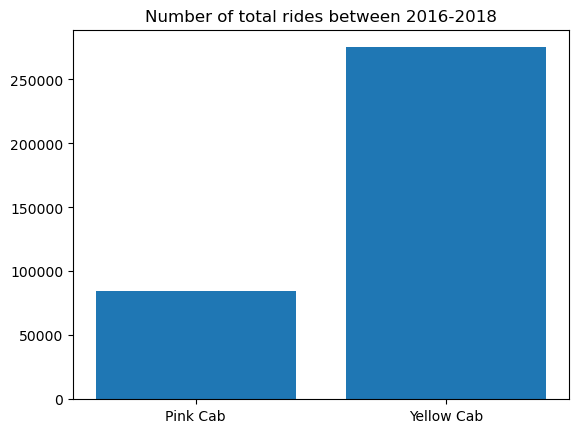

In [175]:
plt.bar(s.index, s.values)
plt.title("Number of total rides between 2016-2018")
plt.show()

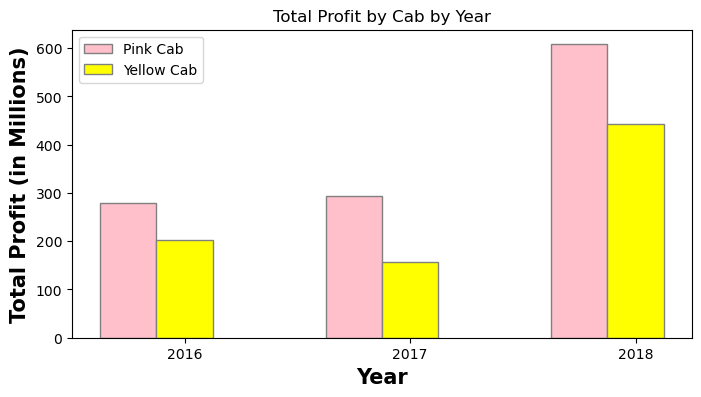

In [177]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(8, 4))
 
# set height of bar
Pink_Cab = a.values[0:3]
Yellow_Cab = a.values[4:7]
 
# Set position of bar on X axis
br1 = np.arange(len(Pink_Cab))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, Pink_Cab, color ='pink', width = barWidth,
        edgecolor ='grey', label ='Pink Cab')
plt.bar(br2, Yellow_Cab, color ='yellow', width = barWidth,
        edgecolor ='grey', label ='Yellow Cab')
 
# Adding Xticks
plt.xlabel('Year', fontweight ='bold', fontsize = 15)
plt.ylabel('Total Profit (in Millions)', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Pink_Cab))],['2016', '2017', '2018'])
plt.title("Total Profit by Cab by Year")
plt.legend()
plt.show()

In [99]:
## which cab service is popular during holidays?
pink = finaldf[finaldf.Company == "Pink Cab"]
yellow = finaldf[finaldf.Company == "Yellow Cab"]

In [100]:
a = pink.groupby(["Holiday"])["Transaction ID"].count()
a

Holiday
4th of July                    279
Christmas Day                  294
Christmas Eve                  608
Columbus Day                   510
Eastern Easter                 203
Juneteenth                     157
Labor Day                      444
Labor Day Weekend              677
Martin Luther King, Jr. Day    129
Memorial Day                   278
New Year's Day                 203
New Year’s Eve                 485
Thanksgiving Day               211
Thanksgiving Eve               220
Valentine’s Day                127
Veterans Day                   444
Washington's Birthday          193
Western Easter                 203
Name: Transaction ID, dtype: int64

In [101]:
b = yellow.groupby(["Holiday"])["Transaction ID"].count()
b

Holiday
4th of July                     878
Christmas Day                   863
Christmas Eve                  1880
Columbus Day                   1490
Eastern Easter                  964
Juneteenth                      402
Labor Day                      1243
Labor Day Weekend              1829
Martin Luther King, Jr. Day     611
Memorial Day                    994
New Year's Day                  681
New Year’s Eve                 1507
Thanksgiving Day                575
Thanksgiving Eve                592
Valentine’s Day                 596
Veterans Day                   1122
Washington's Birthday           834
Western Easter                  967
Name: Transaction ID, dtype: int64

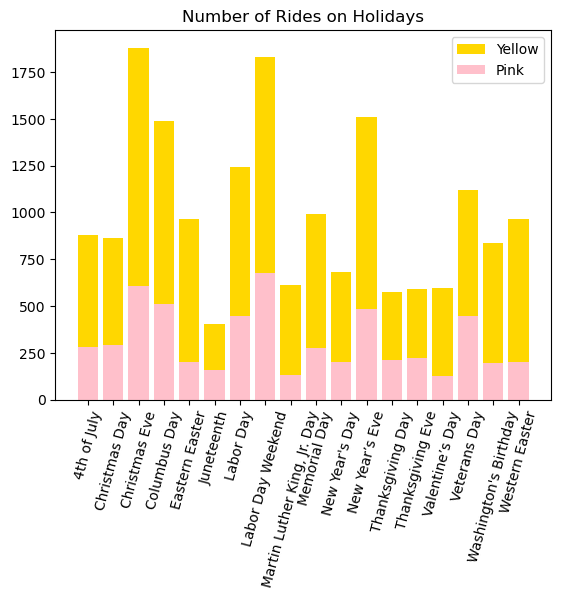

In [120]:
plt.bar(b.index, b.values, label = "Yellow", color = 'gold')
plt.bar(a.index, a.values, label = "Pink", color = "pink")
plt.xticks(rotation = 75)
plt.legend()
plt.title("Number of Rides on Holidays")
plt.show()

In [121]:
#Which gender uses which cab service more?

In [128]:
c = pink.groupby(["Gender"])["Transaction ID"].count()
d = yellow.groupby(["Gender"])["Transaction ID"].count()

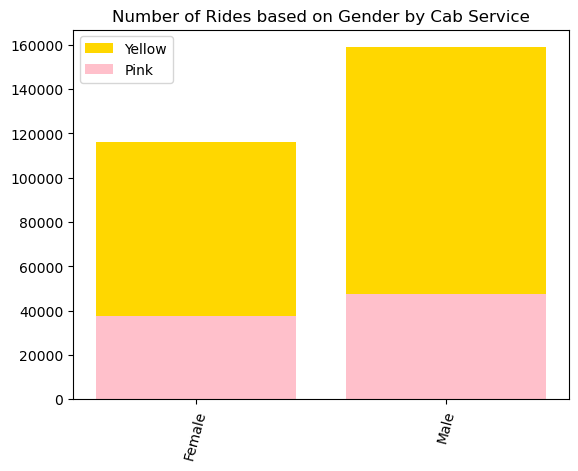

In [127]:
plt.bar(d.index, d.values, label = "Yellow", color = 'gold')
plt.bar(c.index, c.values, label = "Pink", color = "pink")
plt.xticks(rotation = 75)
plt.legend()
plt.title("Number of Rides based on Gender by Cab Service")
plt.show()

In [129]:
#which cab service is more popular in different cities
e = pink.groupby(["City"])["Transaction ID"].count()
f = yellow.groupby(["City"])["Transaction ID"].count()

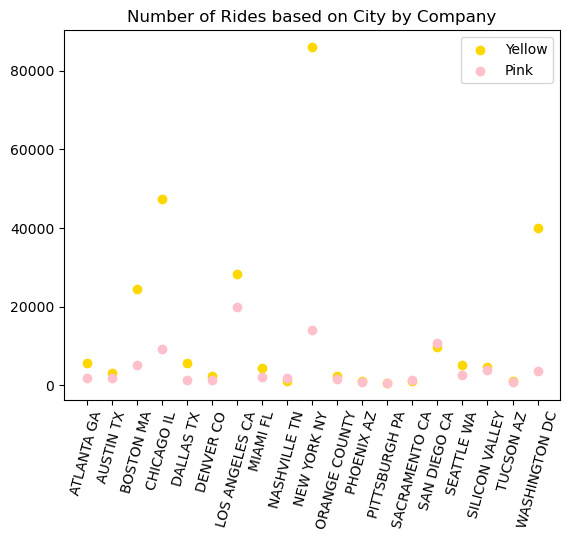

In [178]:
plt.scatter(f.index, f.values, label = "Yellow", color = 'gold')
plt.scatter(e.index, e.values, label = "Pink", color = "pink")
plt.xticks(rotation = 75)
plt.legend()
plt.title("Number of Rides based on City by Company")
plt.show()

In [132]:
#what is the cab with the most income 
g = pink.groupby(["Year"])["Price Charged"].sum()
h = yellow.groupby(["Year"])["Price Charged"].sum()

In [157]:
output = [str(x) for x in g.index]

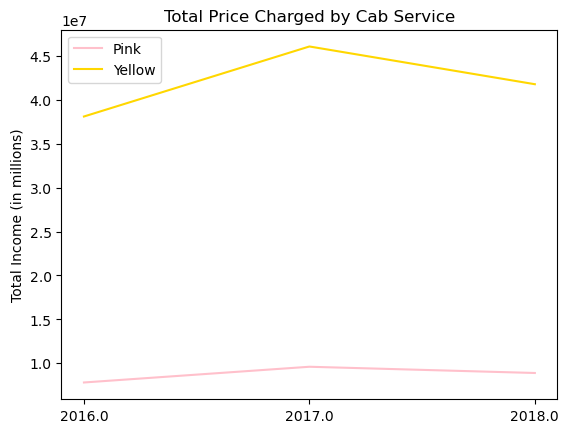

In [182]:
plt.plot(output[:3], g.values[:3], ls = '-', label = "Pink", color = 'pink')
plt.plot(output[:3], h.values[:3], ls = '-', label = "Yellow", color = "gold")
plt.legend()
plt.title("Total Price Charged by Cab Service")
plt.ylabel("Total Income (in millions)")
plt.show()

## Recommendation

We recommend the Yellow Cab based on the following items:

1. Customer Satisfaction: the Yellow Cab is the most trustworthy for customers regardless of location, gender, and holiday.

2. Secure Customer Base: The Yellow Cab has proven to secure a customer base with the number of rides they have given.

3. Financial Future: The Yellow Cab leads in bringing a stable income stream per year.